**Rgerences:**

The implementation of the models are inspired from the following sources:

[1] S. codes), "Stock Price Prediction Using Machine Learning | Deep Learning", Analytics Vidhya, 2020. [Online]. Available: https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/?#?&utm_source=coding-window-blog&source=coding-window-blog.

[2] "yacoubb/stock-trading-ml", GitHub, 2020. [Online]. Available: https://github.com/yacoubb/stock-trading-ml.

In [23]:
# !pip install alpha_vantage
# !pip install fastai==0.7.0
# !pip install scikit-learn==0.21
# !pip install pyramid-arima
# !pip install yfinance

     |████████████████████████████████| 5.5MB 10.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=1b5e44cd405f43d9a69a60a1c5054a07496f3e2ae8473fff349640cbfbdd774d
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [25]:
from alpha_vantage.timeseries import TimeSeries
import json
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastai.structured import add_datepart
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from pyramid.arima import auto_arima
from xgboost import XGBRegressor
from sklearn import preprocessing
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import seaborn as sns
import yfinance as yf
scaler = MinMaxScaler(feature_range=(0, 1))

In [4]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

Dateset fetched from the https://github.com/CNuge/kaggle-code/tree/master/stock_data

In [27]:
df = pd.read_csv("/content/drive/MyDrive/all_stocks_5yr.csv")
min_date = df['date'].min()
max_date = df['date'].max()
df

date   open   high    low  close    volume Name
0       2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1       2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2       2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3       2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4       2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
...            ...    ...    ...    ...    ...       ...  ...
619035  2018-02-01  76.84  78.27  76.69  77.82   2982259  ZTS
619036  2018-02-02  77.53  78.12  76.73  76.78   2595187  ZTS
619037  2018-02-05  76.64  76.92  73.18  73.83   2962031  ZTS
619038  2018-02-06  72.74  74.56  72.13  73.27   4924323  ZTS
619039  2018-02-07  72.70  75.00  72.69  73.86   4534912  ZTS

[619040 rows x 7 columns]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Fetch S&P INEDX data from Yahoo**

In [28]:
snp = yf.Ticker("^GSPC")
df_sp_500 = snp.history(period="max")
df_sp_500.columns = ["SNP_500_" + i if i!= 'Date' else 'Date' for i in df_sp_500.columns]
df_sp_500['Date'] = pd.to_datetime(df_sp_500.index,format='%Y-%m-%d')
df_sp_500 = df_sp_500.reset_index(drop=True)
df_sp_500_all = df_sp_500

df_sp_500_all.to_csv("sp_500_index.csv")

#mask for the dates from 2013 to 2017

mask = (df_sp_500.Date >= min_date) & (df_sp_500.Date <= max_date)
df_sp_500 = df_sp_500.loc[mask]
df_sp_500['Date'] = pd.to_datetime(df_sp_500.Date,format='%Y-%m-%d')
df_sp_500

SNP_500_Open  SNP_500_High  ...  SNP_500_Stock Splits       Date
21373   1509.390015   1518.310059  ...                     0 2013-02-08
21374   1517.930054   1518.310059  ...                     0 2013-02-11
21375   1517.010010   1522.290039  ...                     0 2013-02-12
21376   1519.430054   1524.689941  ...                     0 2013-02-13
21377   1520.329956   1523.140015  ...                     0 2013-02-14
...             ...           ...  ...                   ...        ...
22627   2816.449951   2835.959961  ...                     0 2018-02-01
22628   2808.919922   2808.919922  ...                     0 2018-02-02
22629   2741.060059   2763.389893  ...                     0 2018-02-05
22630   2614.780029   2701.040039  ...                     0 2018-02-06
22631   2690.949951   2727.669922  ...                     0 2018-02-07

[1259 rows x 8 columns]

**Utility functions**

In [ ]:
sp_all = list()

def create_sp_list():
    sp_all = list()
    df_temp1 = df.drop_duplicates('Name')

    for each in df_temp1['Name'][:1]:
        df_apple = df.loc[df['Name'] == each]
        if df_apple.shape[0] > 1200:
            df_apple['Date'] = pd.to_datetime(df_apple.date,format='%Y-%m-%d')
            df_apple = pd.merge(df_apple, df_sp_500, how='outer', on='Date')
            df_apple.index = df_apple['Date']
            df_apple = df_apple.drop("date",axis=1)
            df_apple = df_apple.sort_index(ascending=True, axis=0)
            df_apple = df_apple.dropna()
            sp_all.append(df_apple)
    return sp_all

# f = create_sp_list()

In [13]:
stock_name = ['AAPL','MSFT','GOOGL','AMZN','NFLX']

In [ ]:
df_apple = df.loc[df['Name'] == "AAPL"]
df_apple.shape,df_apple.head(),df_apple.tail()

df_apple['Date'] = pd.to_datetime(df_apple.date,format='%Y-%m-%d')
df_apple.index = df_apple['Date']
df_apple = df_apple.drop("date",axis=1)
df_apple = df_apple.sort_index(ascending=True, axis=0)
df_apple.head()

open     high      low    close     volume  Name       Date
Date                                                                      
2013-02-08  67.7142  68.4014  66.8928  67.8542  158168416  AAPL 2013-02-08
2013-02-11  68.0714  69.2771  67.6071  68.5614  129029425  AAPL 2013-02-11
2013-02-12  68.5014  68.9114  66.8205  66.8428  151829363  AAPL 2013-02-12
2013-02-13  66.7442  67.6628  66.1742  66.7156  118721995  AAPL 2013-02-13
2013-02-14  66.3599  67.3771  66.2885  66.6556   88809154  AAPL 2013-02-14

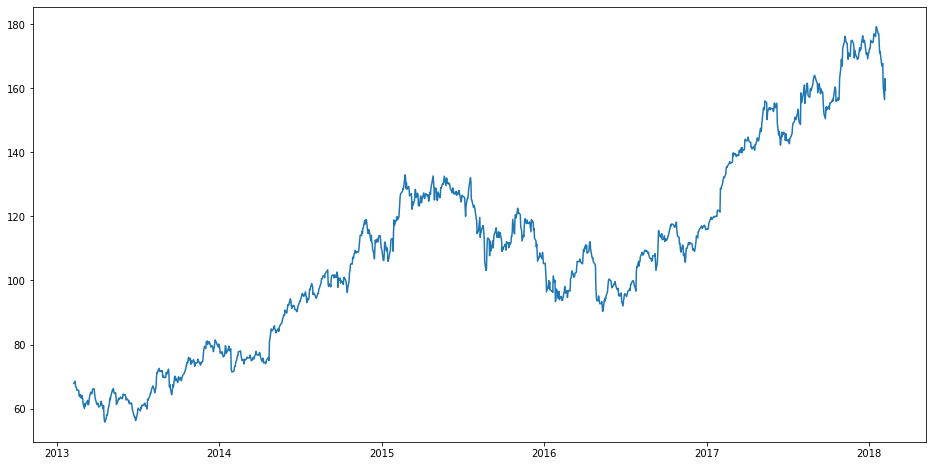

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(sp_all[1]['close'], label='Close Price history')

ML algorithms [1]

**Moving average**

In [ ]:
start_date = '2013-01-01'
end_date = '2017-04-01'

def make_train_valid(df_apple):
    mask = (df_apple.index > start_date) & (df_apple.index <= end_date)
    train = df_apple.loc[mask]
    valid = df_apple.loc[df_apple.index > end_date]

    return train,valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 


 RMSE value on validation set of AAL : 
3.773836386485027


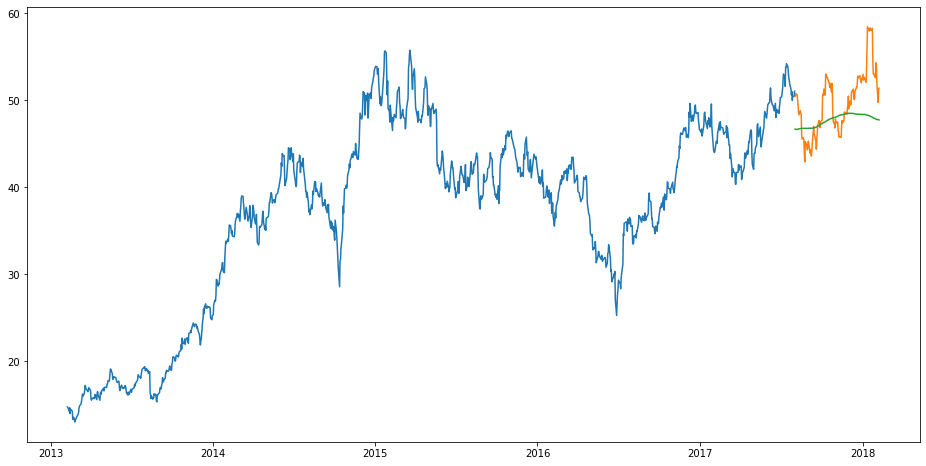


 RMSE value on validation set of AAPL : 
19.860687053776218


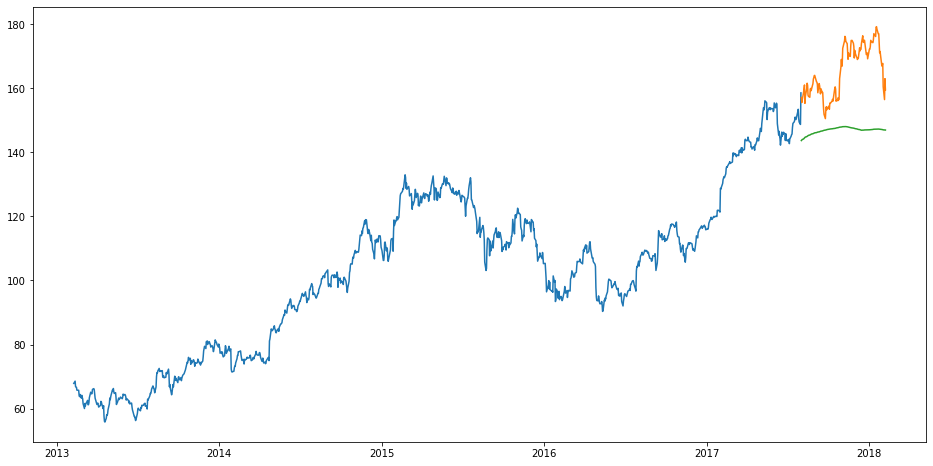

In [ ]:
sp_all = create_sp_list()
for df_apple in sp_all[:]:
    apple_train,apple_valid = make_train_valid(df_apple)

    preds = []
    for i in range(0,apple_valid.shape[0]):
        a = apple_train['close'][len(apple_train)-apple_valid.shape[0]+i:].sum() + sum(preds)
        b = a/apple_valid.shape[0]
        preds.append(b)
    rms=np.sqrt(np.mean(np.power((np.array(apple_valid['close'])-preds),2)))
    print('\n RMSE value on validation set of ' + df_apple['Name'][0] + " : ")
    print(rms)

    apple_valid['Predictions'] = 0
    apple_valid['Predictions'] = preds
    plt.figure(figsize=(16,8))
    plt.plot(apple_train['close'])
    plt.plot(apple_valid[['close', 'Predictions']])
    plt.show()

**Linear Regression**

AAPL 20.807568241420178


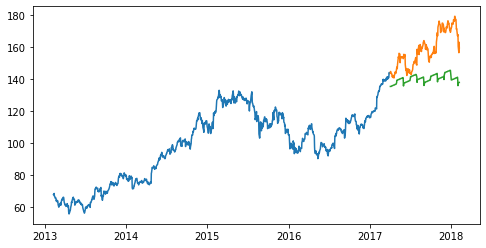

AMZN 237.6869167200972


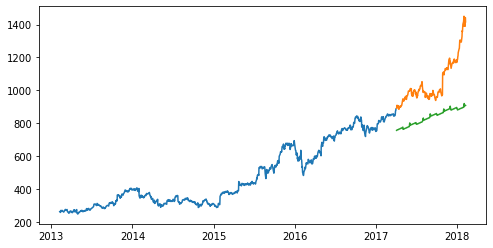

GOOGL 132.87025529143608


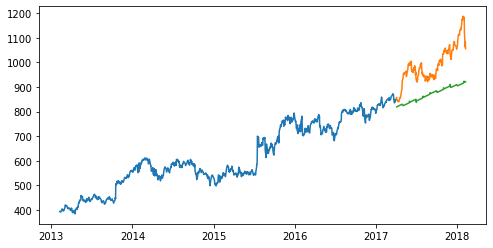

MSFT 12.773526998619554


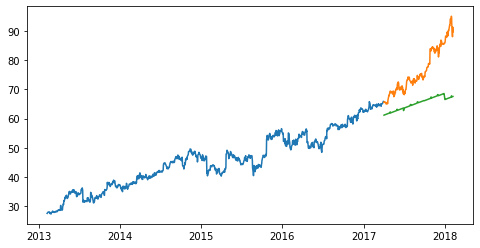

NFLX 45.98734179970198


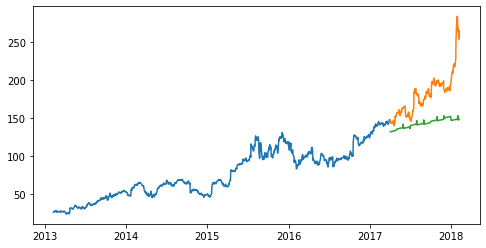

In [ ]:
#make features

sp_all = create_sp_list()
error = {}

for df_each in sp_all[:]:
    df_each = df_each[['Date','close','Name']]
    add_datepart(df_each,'Date')
    df_each.drop('Elapsed', axis=1, inplace=True)

    train,valid = make_train_valid(df_each)
    name = train['Name'][0]
    train = train.drop("Name",axis=1)
    valid = valid.drop("Name",axis=1)

    x_train = train.drop('close', axis=1)
    y_train = train['close']
    x_valid = valid.drop('close', axis=1)
    y_valid = valid['close']

    model = LinearRegression()
    model.fit(x_train,y_train)

    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    error[name] = rms
    valid['Predictions'] = 0
    valid['Predictions'] = preds

    if name in stock_name:
        print(name,rms)
        plt.figure(figsize=(8,4))
        plt.plot(train['close'])
        plt.plot(valid[['close', 'Predictions']])
        plt.show()

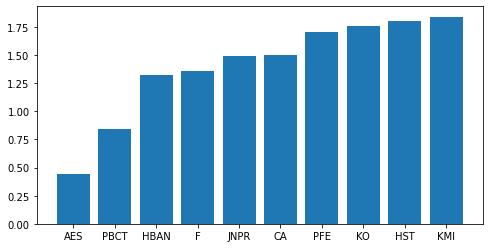

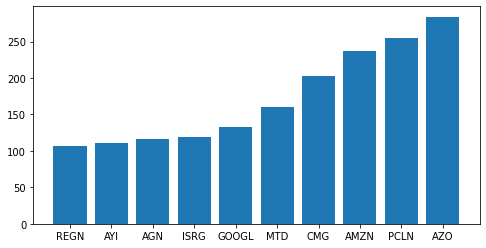

In [ ]:
error = dict(sorted(error.items(), key=lambda item: item[1]))
keys, values = zip(*error.items()) 

len(keys),len(values)
plt.figure(figsize=(8,4))
plt.bar(keys[:10], values[:10])
plt.show()
plt.figure(figsize=(8,4))
plt.bar(keys[-10:], values[-10:])
plt.show()
error_linear = error

save = pd.DataFrame.from_dict([error_linear])
save.to_csv("/content/drive/MyDrive/DAL/mlbd/linear.csv")

**k-Nearest Neighbours**

AAPL 85.1244012592709


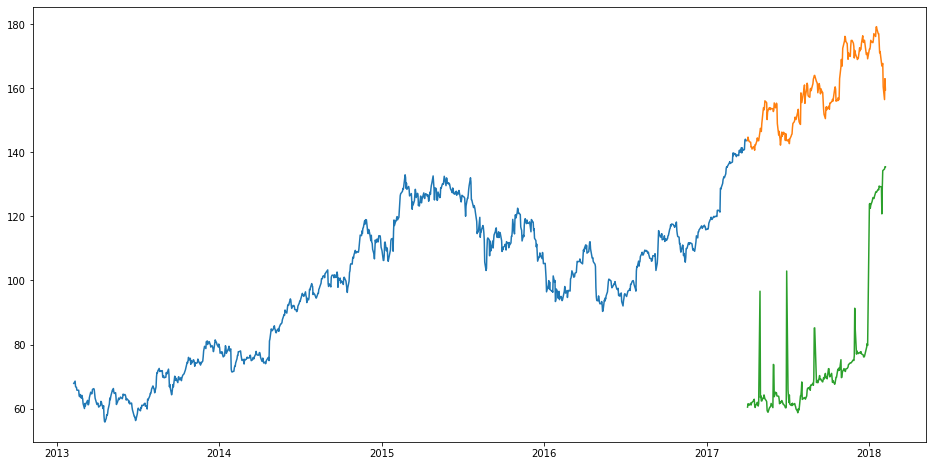

AMZN 689.8857333149942


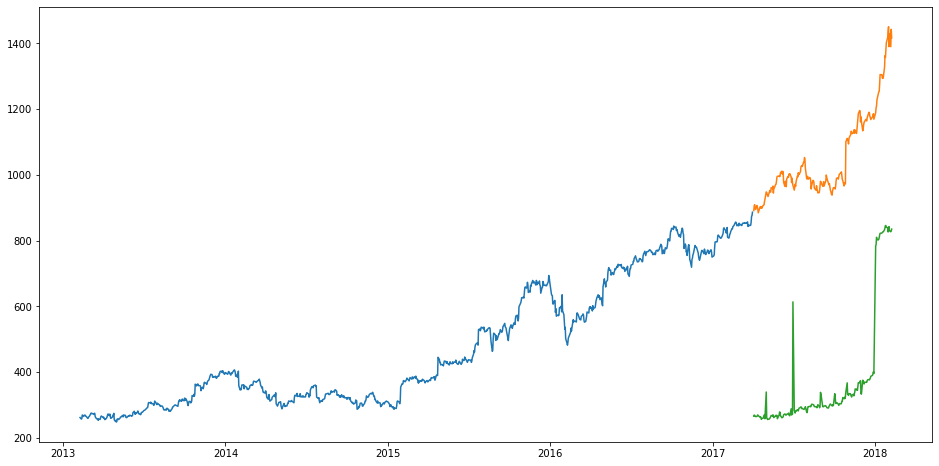

GOOGL 473.3481003463644


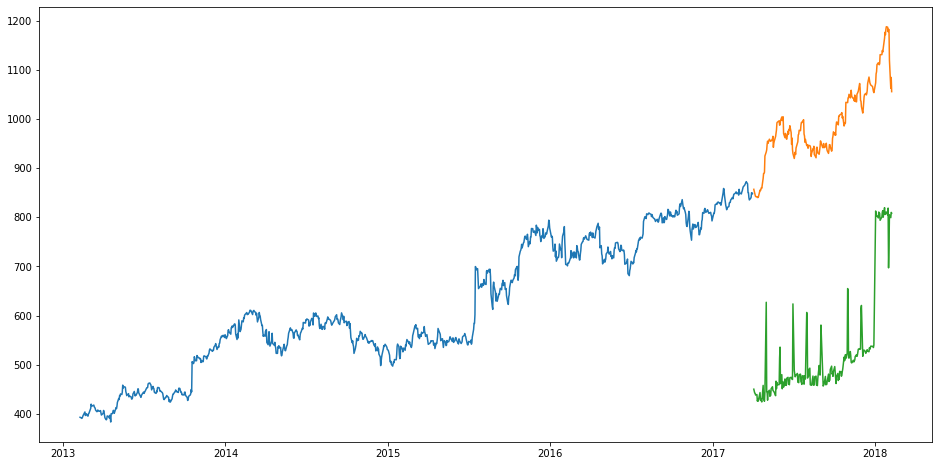

MSFT 39.60260982335546


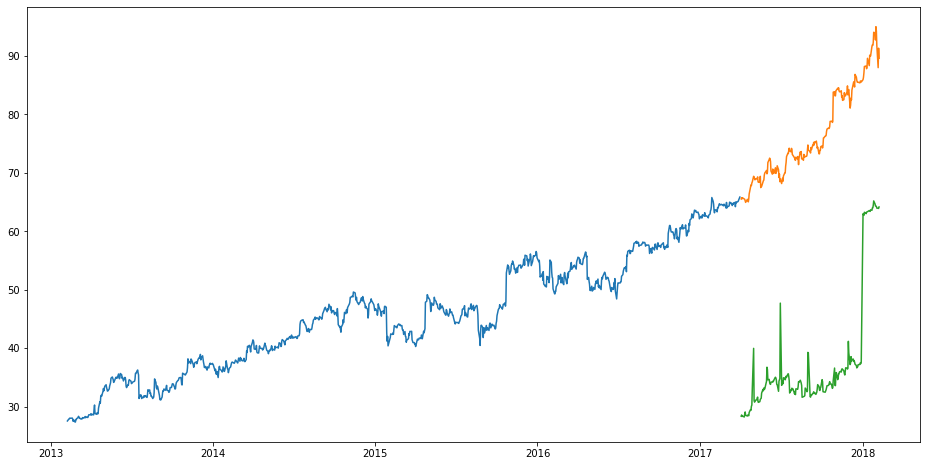

NFLX 130.26301928316514


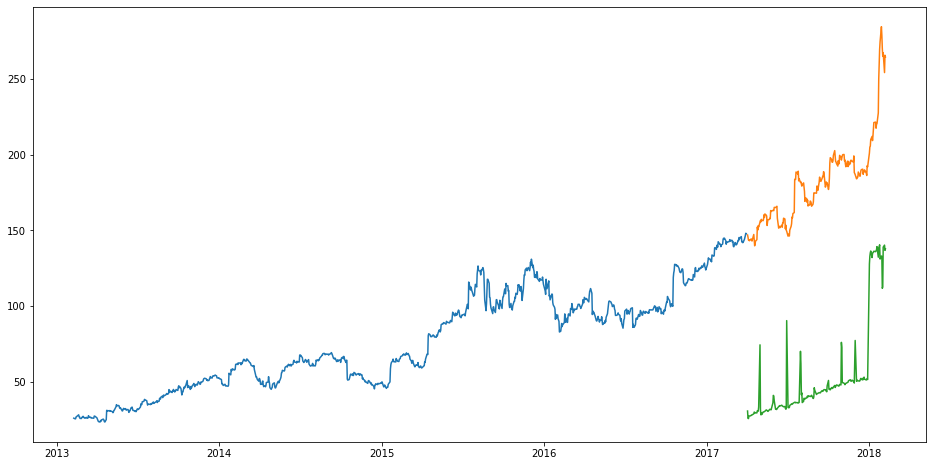

In [ ]:
sp_all = create_sp_list()
error = {}

for df_each in sp_all[:]:
    df_each = df_each[['Date','close','Name']]
    add_datepart(df_each,'Date')
    df_each.drop('Elapsed', axis=1, inplace=True)
    
    train,valid = make_train_valid(df_each)
    name = train['Name'][0]
    train = train.drop("Name",axis=1)
    valid = valid.drop("Name",axis=1)

    x_train = train.drop('close', axis=1)
    y_train = train['close']
    x_valid = valid.drop('close', axis=1)
    y_valid = valid['close']

    x_train_scaled = scaler.fit_transform(x_train)
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(x_valid)
    x_valid = pd.DataFrame(x_valid_scaled)

    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)

    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    error[name] = rms

    valid['Predictions'] = 0
    valid['Predictions'] = preds
    
    if name in stock_name:
        print(name,rms)
        plt.figure(figsize=(16,8))
        plt.plot(train['close'])
        plt.plot(valid[['close', 'Predictions']])
        plt.show()


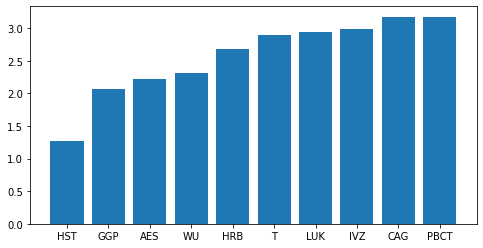

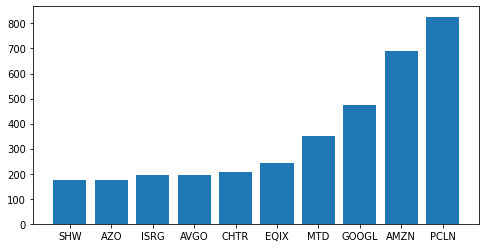

In [ ]:
error = dict(sorted(error.items(), key=lambda item: item[1]))
keys, values = zip(*error.items()) 

len(keys),len(values)
plt.figure(figsize=(8,4))
plt.bar(keys[:10], values[:10])
plt.show()
plt.figure(figsize=(8,4))
plt.bar(keys[-10:], values[-10:])
plt.show()
error_knn = error

save = pd.DataFrame.from_dict([error_knn])
save.to_csv("/content/drive/MyDrive/DAL/mlbd/knn.csv")

**Random Forests**

AAPL 62.99765193248632


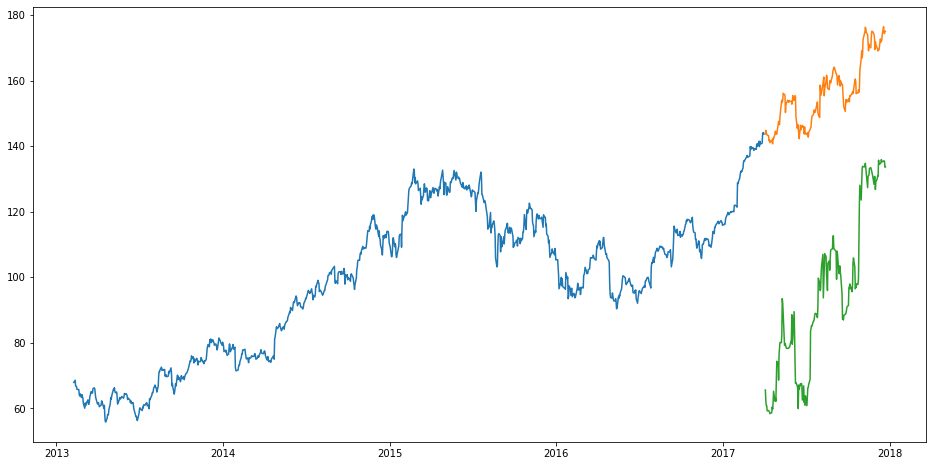

AMZN 517.3778257006084


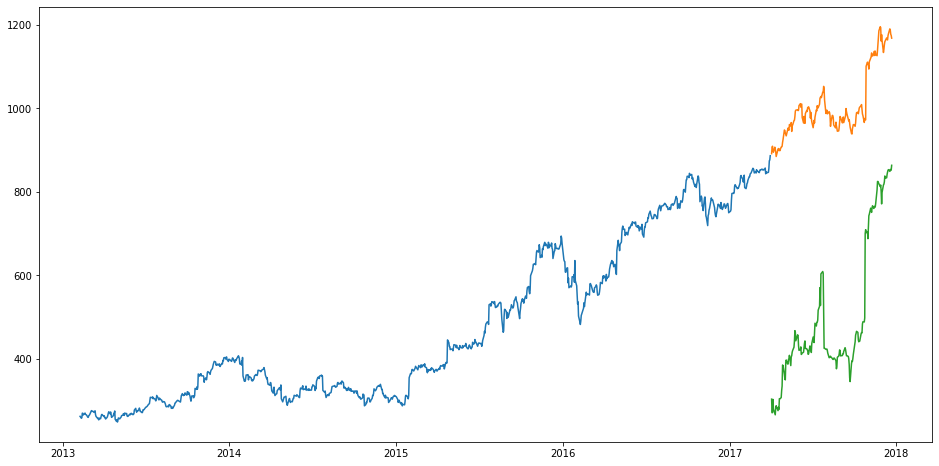

GOOGL 331.9163835982862


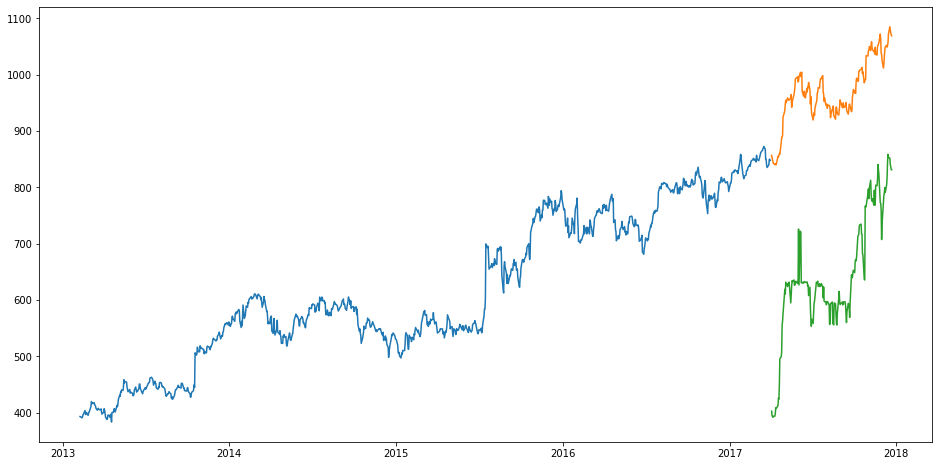

MSFT 30.684867635630273


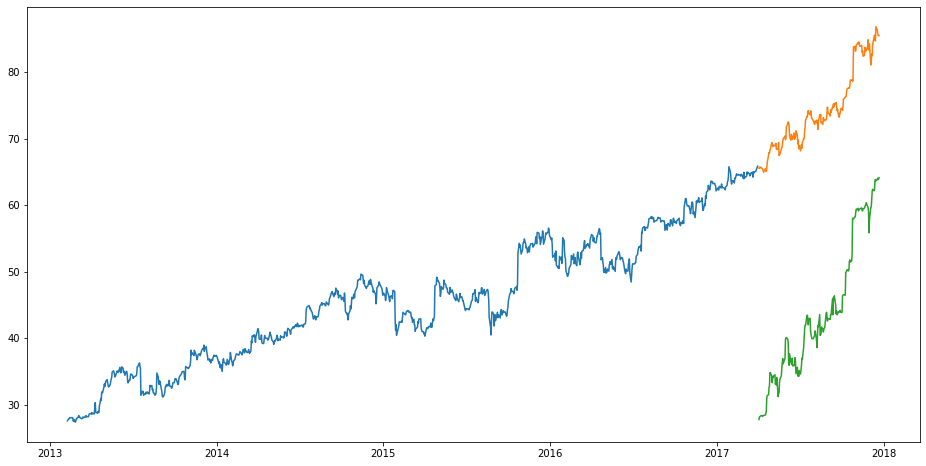

NFLX 91.93327671696338


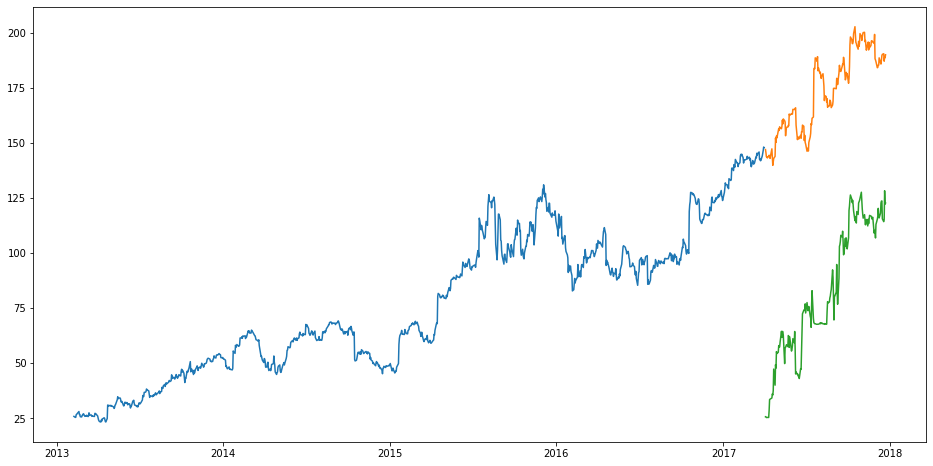

In [ ]:
sp_all = create_sp_list()
error = {}

for df_each in sp_all[:]:
    df_each = df_each[['Date','close','Name']]
    add_datepart(df_each,'Date')
    df_each.drop('Elapsed', axis=1, inplace=True)

    for d in range(2, 31):
        col = "%dd" % d
        df_each[col] = df_each['close'].shift(-1 * d)
    
    df_each = df_each.dropna()

    train,valid = make_train_valid(df_each)
    name = train['Name'][0]
    train = train.drop("Name",axis=1)
    valid = valid.drop("Name",axis=1)

    x_train = train.drop('close', axis=1)
    y_train = train['close']
    x_valid = valid.drop('close', axis=1)
    y_valid = valid['close']

    x_train_scaled = scaler.fit_transform(x_train)
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(x_valid)
    x_valid = pd.DataFrame(x_valid_scaled)

    grid = RandomForestRegressor(
        n_estimators=100,
        criterion='mse',
       )

    grid.fit(x_train, y_train)
    preds = grid.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    error[name] = rms

    valid['Predictions'] = 0
    valid['Predictions'] = preds

    if name in stock_name:
        print(name,rms)
        plt.figure(figsize=(16,8))
        plt.plot(train['close'])
        plt.plot(valid[['close', 'Predictions']])
        plt.show()

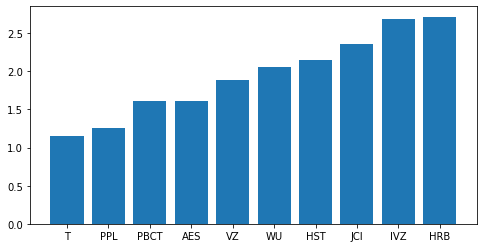

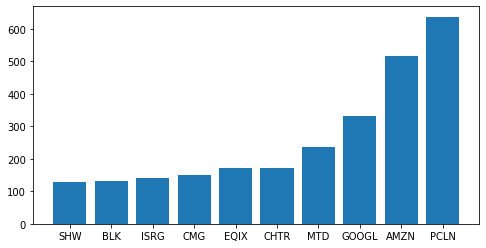

In [ ]:
error = dict(sorted(error.items(), key=lambda item: item[1]))
keys, values = zip(*error.items()) 

len(keys),len(values)
plt.figure(figsize=(8,4))
plt.bar(keys[:10], values[:10])
plt.show()
plt.figure(figsize=(8,4))
plt.bar(keys[-10:], values[-10:])
plt.show()
error_forest = error

save = pd.DataFrame.from_dict([error_forest])
save.to_csv("/content/drive/MyDrive/DAL/mlbd/forest.csv")

In [ ]:
combined_mse = pd.DataFrame.from_dict([error_linear, error_knn,error_forest])
combined_mse.to_csv("combined_mse.csv")

**Auto ARIMA**

{'AAL': 4.832328906674075}
{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319}
AAPL 10.109900031981319


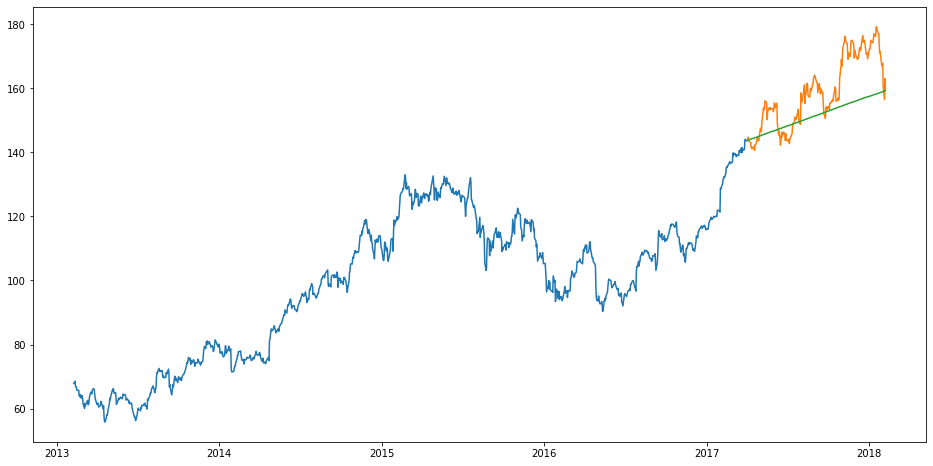

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405}
{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126}
{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324}
{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349}
{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866}
{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656}
{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178}
{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.67

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163}
{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.77

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102}
{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.62

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695}
{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802}


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386}
AMZN 143.361

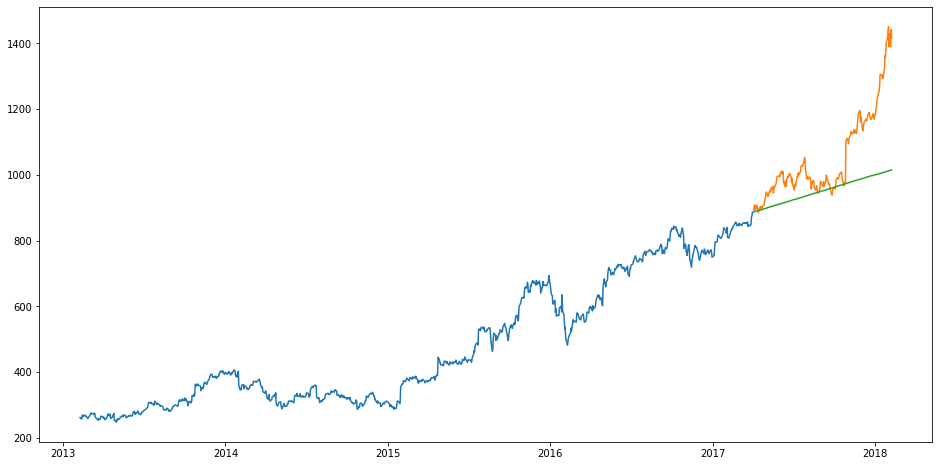

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

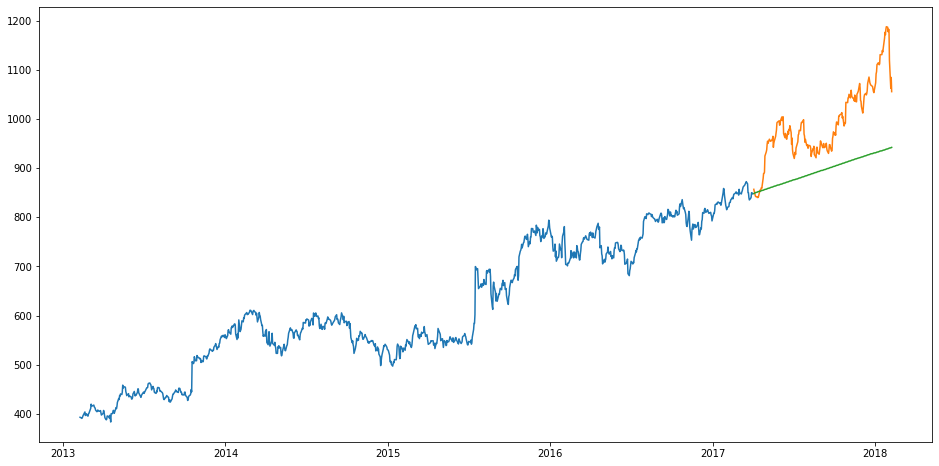

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

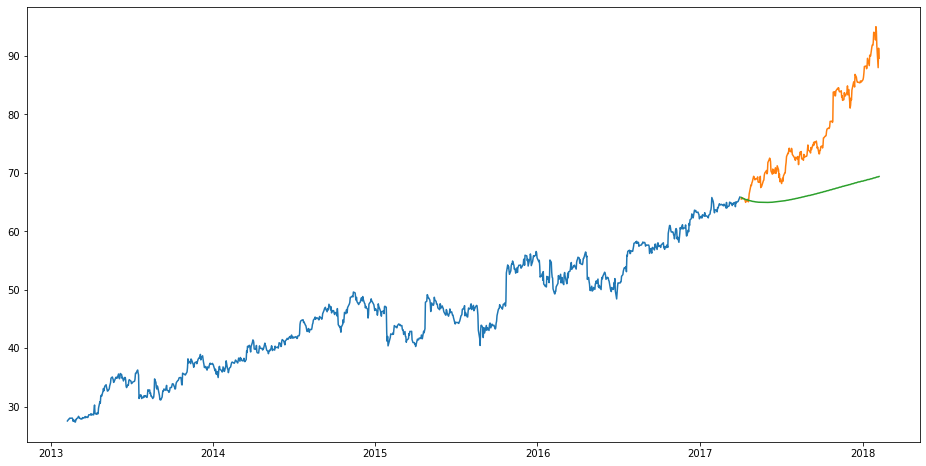

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

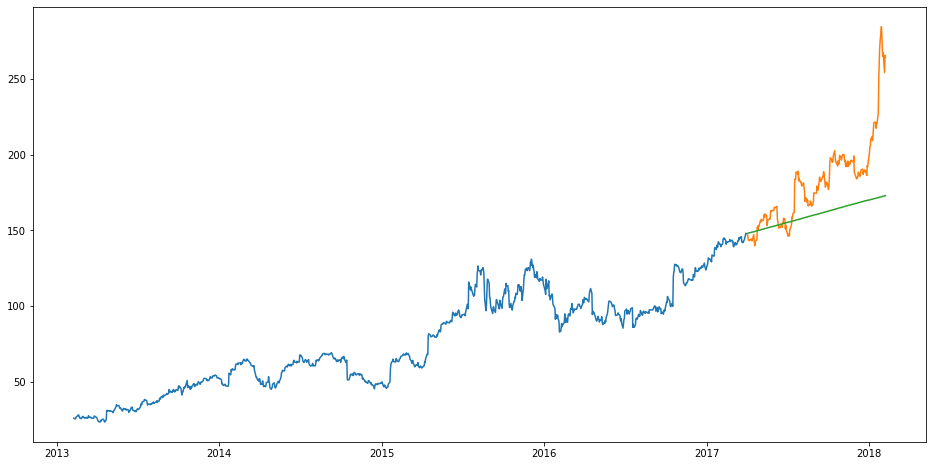

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'AAL': 4.832328906674075, 'AAPL': 10.109900031981319, 'AAP': 50.707804586285505, 'ABBV': 19.435098959939843, 'ABC': 9.43090747712405, 'ABT': 7.626035198106126, 'ACN': 13.920242561336995, 'ADBE': 32.74834563427324, 'ADI': 4.109333747458644, 'ADM': 6.136389446386349, 'ADP': 5.406125621596597, 'ADSK': 19.772874754063558, 'ADS': 24.893922562426738, 'AEE': 2.6764219758193866, 'AEP': 3.303525021814656, 'AES': 0.3673142853847917, 'AET': 26.696840020181273, 'AFL': 7.633458032427333, 'AGN': 57.59498861458909, 'AIG': 3.8223690327404385, 'AIV': 2.7437590827975984, 'AIZ': 6.578961958820433, 'AJG': 3.353877003796995, 'AKAM': 10.132524979890178, 'ALB': 15.23958592947338, 'ALGN': 76.96737027760163, 'ALK': 24.257343694144932, 'ALL': 8.761780018139495, 'ALXN': 12.40091311801932, 'AMAT': 7.869250460692073, 'AMD': 8.136275341095724, 'AME': 11.267265655655102, 'AMGN': 7.225530106978099, 'AMG': 21.25770947377695, 'AMP': 16.81744319439492, 'AMT': 12.246568561811802, 'AMZN': 143.36185015265386, 'ANDV': 17.9

In [ ]:
sp_all = create_sp_list()
error = {}

for df_each in sp_all[:]:
    df_each = df_each[['Date','close','Name']]
    train,valid = make_train_valid(df_each)
    name = train['Name'][0]
    training = train.drop("Name",axis=1)
    validation = valid.drop("Name",axis=1)

    train = training['close']

    model = auto_arima(train,n_jobs=-1)
    model.fit(train)

    forecast = model.predict(n_periods=validation.shape[0])
    forecast = pd.DataFrame(forecast,index = validation.index,columns=['Prediction'])

    rms=np.sqrt(np.mean(np.power((np.array(validation['close'])-np.array(forecast['Prediction'])),2)))
    error[name] = rms
    print(error)

    if name in stock_name:
        print(name,rms)
        plt.figure(figsize=(16,8))
        plt.plot(training['close'])
        plt.plot(validation['close'])
        plt.plot(forecast['Prediction'])
        plt.show()

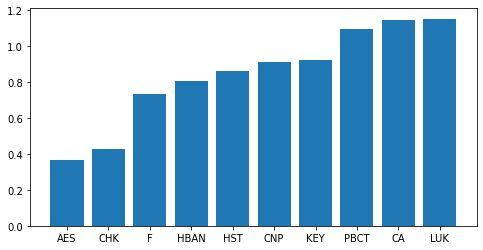

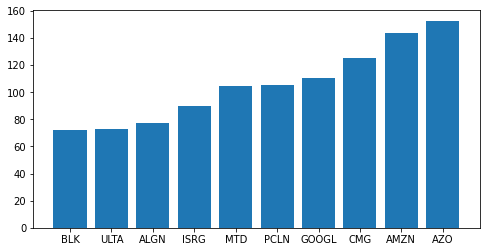

In [ ]:
error = dict(sorted(error.items(), key=lambda item: item[1]))
keys, values = zip(*error.items()) 

len(keys),len(values)
plt.figure(figsize=(8,4))
plt.bar(keys[:10], values[:10])
plt.show()
plt.figure(figsize=(8,4))
plt.bar(keys[-10:], values[-10:])
plt.show()
error_arima = error


save = pd.DataFrame.from_dict([error_arima])
save.to_csv("/content/drive/MyDrive/DAL/mlbd/forest.csv")

**Xg-boost**

In [ ]:
#make features

sp_all = create_sp_list()
error = {}

for df_each in sp_all[:]:
    add_datepart(df_each,'Date')
    df_each.drop('Elapsed', axis=1, inplace=True)
    
    train,valid = make_train_valid(df_each)
    # print(train)
    name = train['Name'][0]
    train = train.drop("Name",axis=1)
    valid = valid.drop("Name",axis=1)

    x_train = train.drop('close', axis=1)
    y_train = train['close']
    x_valid = valid.drop('close', axis=1)
    y_valid = valid['close']

    model = XGBRegressor(n_estimators=15,max_depth=10,learning_rate=0.3)
    model.fit(x_train, y_train)
    preds = model.predict(x_valid)

    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    error[name] = rms
    valid['Predictions'] = 0
    valid['Predictions'] = preds

    # valid.index = valid.index
    # train.index = train.index
    # plt.figure(figsize=(16,8))
    # plt.plot(train['close'])
    # plt.plot(valid[['close', 'Predictions']])
    # plt.show()
    # break

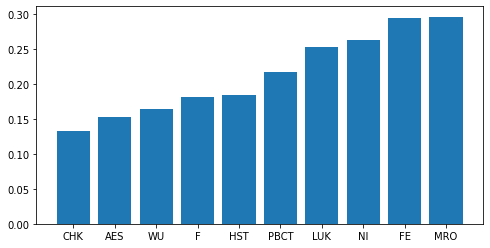

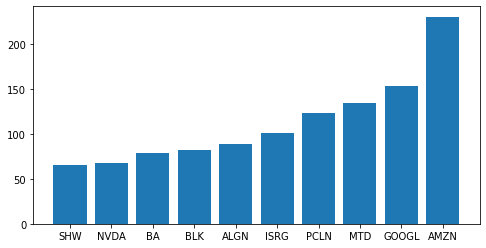

In [ ]:
error = dict(sorted(error.items(), key=lambda item: item[1]))
keys, values = zip(*error.items()) 

len(keys),len(values)
plt.figure(figsize=(8,4))
plt.bar(keys[:10], values[:10])
plt.show()
plt.figure(figsize=(8,4))
plt.bar(keys[-10:], values[-10:])
plt.show()
error_xgboost = error

Recurrent Neaural Network [2]

**LSTM**

In [ ]:
def prepare_data(df_each):
    data = df_each.reset_index(drop=True)
    data = data.drop('Name', axis=1)
    data = data.drop('Date', axis=1)
    data = data.values

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)

    return ohlcv_histories_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser

AAPL 11.075164249747832


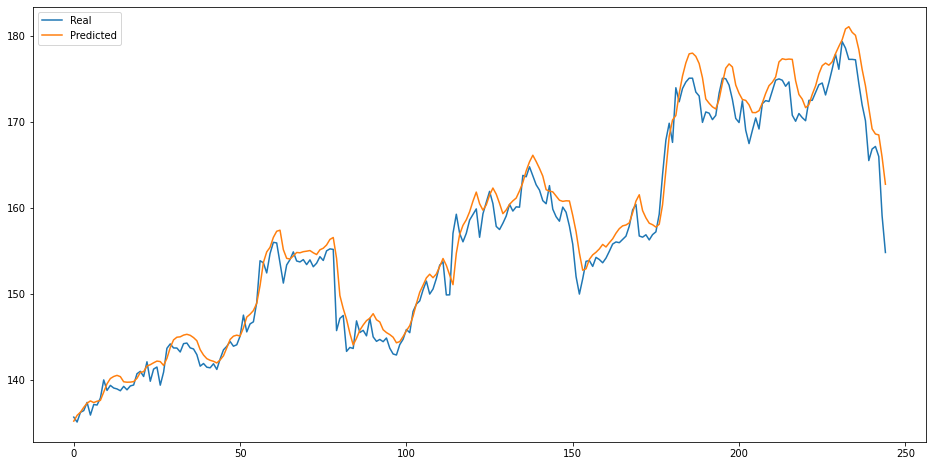

AMZN 167.108258195043


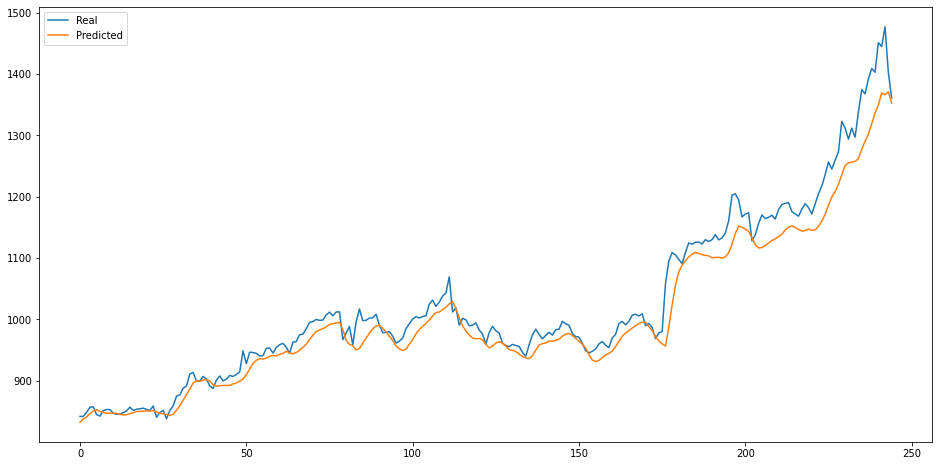

GOOGL 52.85264511777636


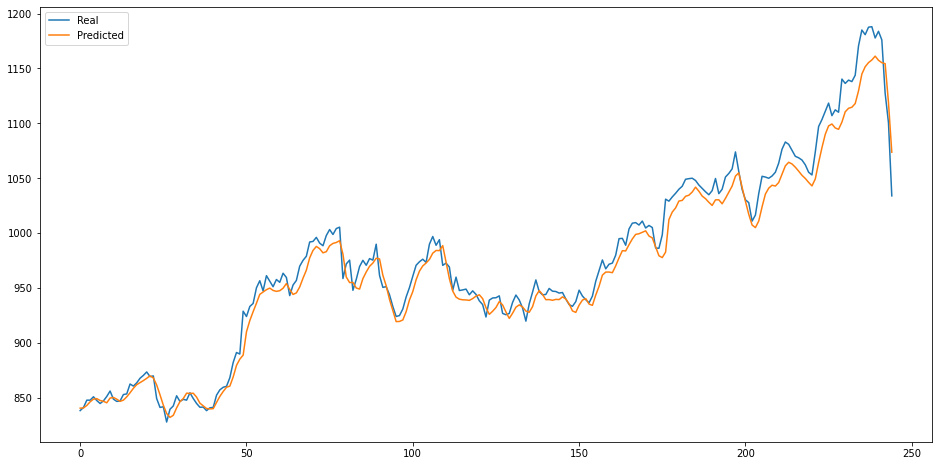

MSFT 2.6476651839683973


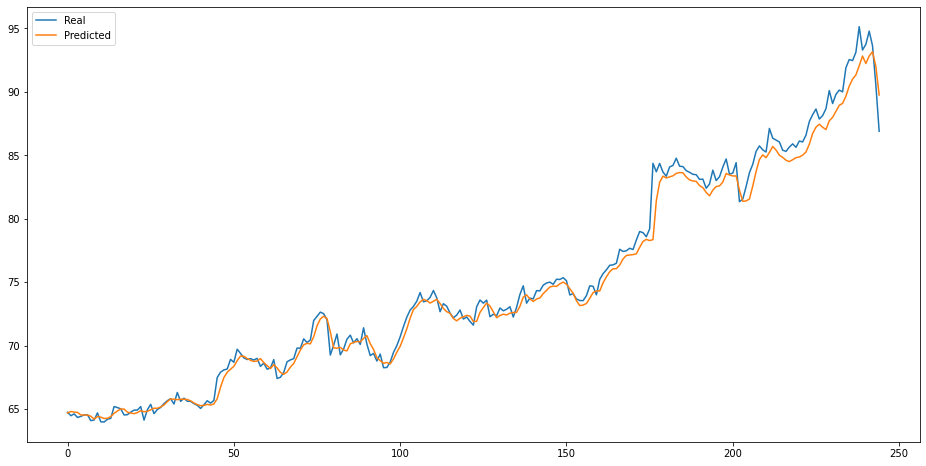

NFLX 23.32278856423217


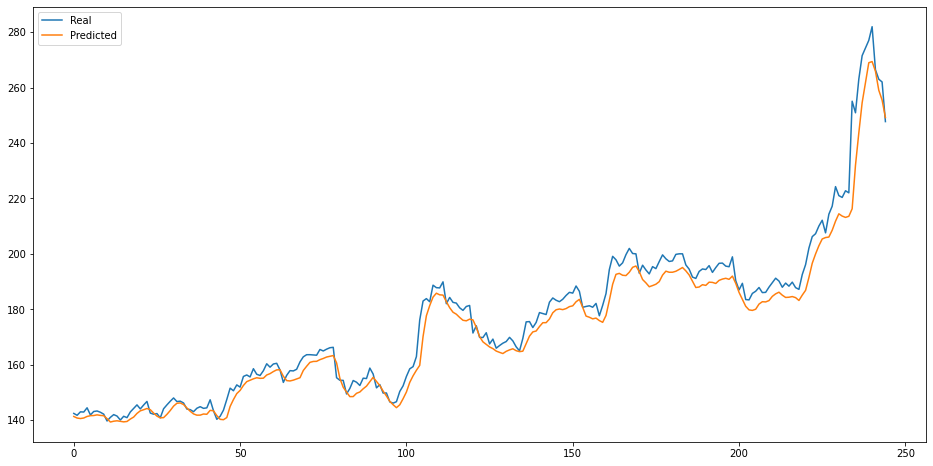

In [ ]:
history_points = 30
test_split = 0.8
error = {}
sp_all = create_sp_list()

for df_each in sp_all[:]:
    name = df_each['Name'][0]
    if name in stock_name:
        np.random.seed(4)
        tf.random.set_seed(4)
        ohlcv_histories, next_day_open_values, unscaled_y, y_normaliser = prepare_data(df_each)
        n = int(ohlcv_histories.shape[0] * test_split)
        ohlcv_train = ohlcv_histories[:n]
        y_train = next_day_open_values[:n]

        ohlcv_test = ohlcv_histories[n:]
        y_test = next_day_open_values[n:]

        unscaled_y_test = unscaled_y[n:]

        lstm_input = Input(shape=(history_points, 5), name='lstm_input')
        x = LSTM(50, name='lstm_0')(lstm_input)
        x = Dropout(0.2, name='lstm_dropout_0')(x)
        x = Dense(64, name='dense_0')(x)
        x = Activation('sigmoid', name='sigmoid_0')(x)
        x = Dense(1, name='dense_1')(x)
        output = Activation('linear', name='linear_output')(x)
        model = Model(inputs=lstm_input, outputs=output)

        adam = optimizers.Adam(lr=0.0005)
        model.compile(optimizer=adam, loss='mse')

        model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=100, shuffle=True, validation_split=0.1,verbose=0)

        y_test_predicted = model.predict(ohlcv_test)
        y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
        y_predicted = model.predict(ohlcv_histories)
        y_predicted = y_normaliser.inverse_transform(y_predicted)

        real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
        scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
        error[name] = scaled_mse
        print(name,scaled_mse)
        start = 0
        end = -1
        plt.figure(figsize=(16,8))
        real = plt.plot(unscaled_y_test[start:end], label='real')
        pred = plt.plot(y_test_predicted[start:end], label='predicted')

        plt.legend(['Real', 'Predicted'])
        plt.show()


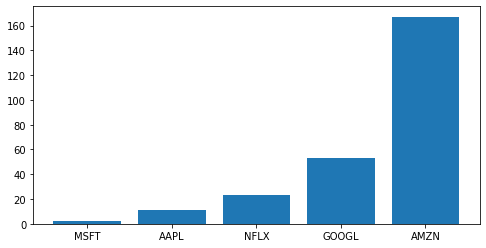

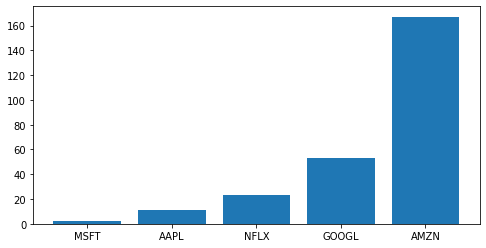

In [ ]:
error = dict(sorted(error.items(), key=lambda item: item[1]))
keys, values = zip(*error.items()) 

len(keys),len(values)
plt.figure(figsize=(8,4))
plt.bar(keys[:10], values[:10])
plt.show()
plt.figure(figsize=(8,4))
plt.bar(keys[-10:], values[-10:])
plt.show()
error_lstm = error

In [ ]:
error_lstm = pd.DataFrame.from_dict([error_lstm])
error_lstm.to_csv("/content/drive/MyDrive/DAL/error_lstm.csv")

**LSTM-SMA**

In [14]:
def prepare_data_SMA_macd(df_each):
    data = df_each.reset_index(drop=True)

    if 'Name' in df_each.columns:
        data = data.drop('Name', axis=1)

    data = data.drop('Date', axis=1)
    # print(data.head())
    data = data.values

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    # data_normalised = data

    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    # print(ohlcv_histories_normalised,"--prvious")
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    # print(next_day_open_values,"--privious y")

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)

    def calc_ema(values, time_period):
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalised:
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma]))

        # technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser

**LSTM-SMA**

AAPL 3.6435557794682736


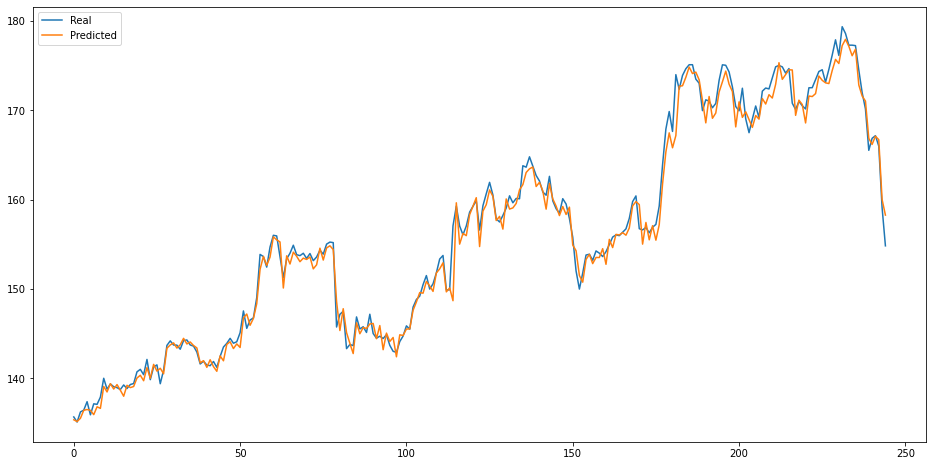

AMZN 45.25298641422167


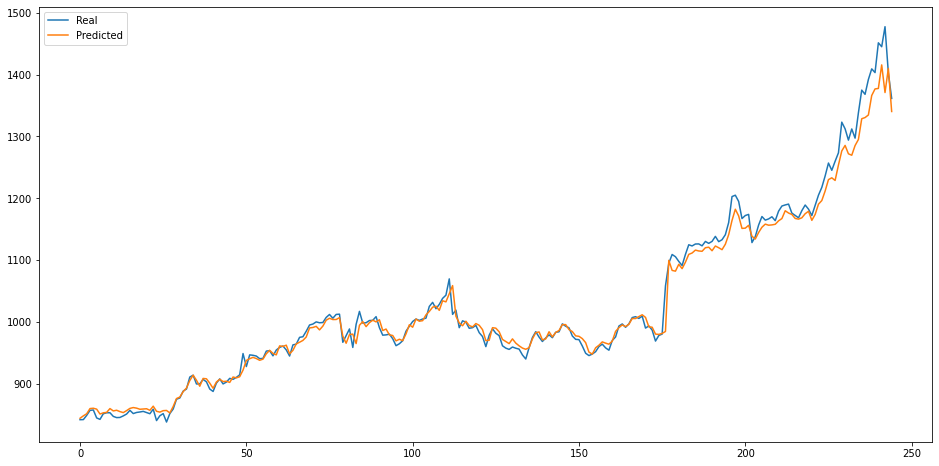

GOOGL 32.00197455444821


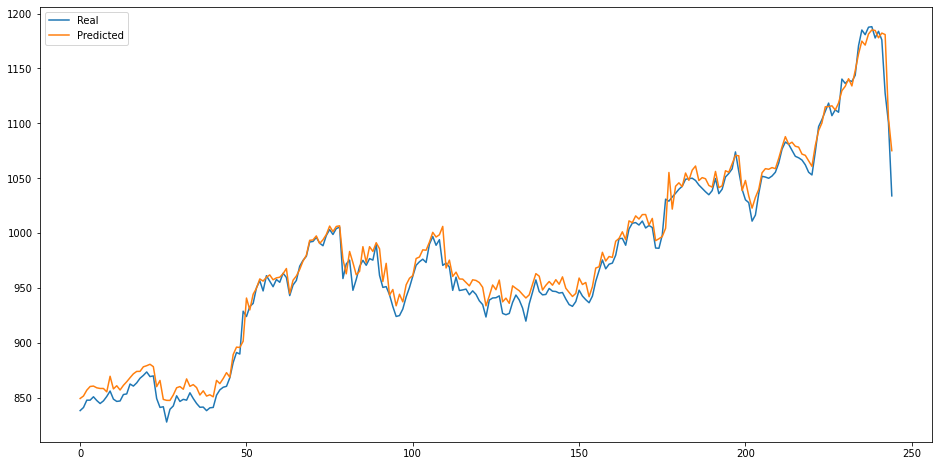

MSFT 7.456890730557911


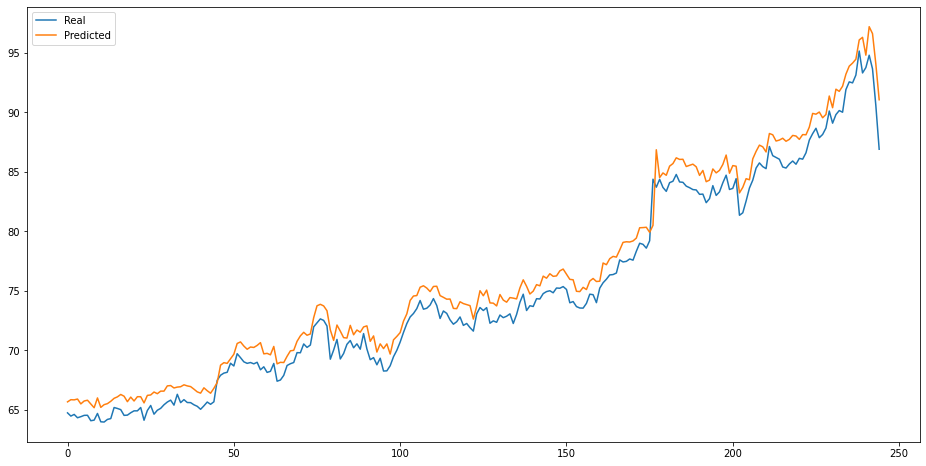

NFLX 11.929133463394072


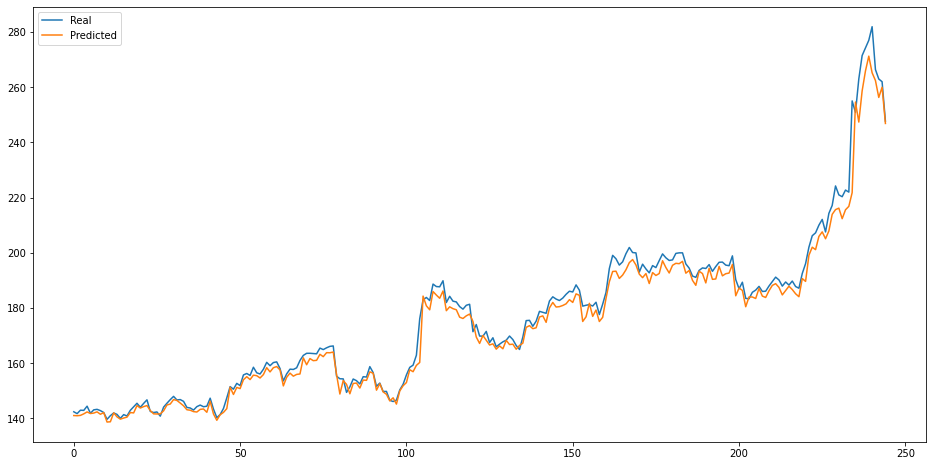

In [ ]:
history_points = 30
test_split = 0.8
error = {}
sp_all = create_sp_list()

for df_each in sp_all[:]:
    name = df_each['Name'][0]
    if name in stock_name:
        np.random.seed(4)
        tf.random.set_seed(4)
        ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = prepare_data_SMA_macd(df_each)
        n = int(ohlcv_histories.shape[0] * test_split)

        ohlcv_train = ohlcv_histories[:n]
        tech_ind_train = technical_indicators[:n]
        y_train = next_day_open_values[:n]

        ohlcv_test = ohlcv_histories[n:]
        tech_ind_test = technical_indicators[n:]
        y_test = next_day_open_values[n:]

        unscaled_y_test = unscaled_y[n:]

        lstm_input = Input(shape=(history_points, 11), name='lstm_input')
        dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

        x = LSTM(64, name='lstm_0')(lstm_input)
        x = Dropout(0.2, name='lstm_dropout_0')(x)
        lstm_branch = Model(inputs=lstm_input, outputs=x)
        y = Dense(20, name='tech_dense_0')(dense_input)
        y = Activation("relu", name='tech_relu_0')(y)
        y = Dropout(0.2, name='tech_dropout_0')(y)
        technical_indicators_branch = Model(inputs=dense_input, outputs=y)

        combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

        z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
        z = Dense(1, activation="linear", name='dense_out')(z)

        model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
        adam = optimizers.Adam(lr=0.0005)
        model.compile(optimizer=adam, loss='mse')
        model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=16, epochs=250, shuffle=True, validation_split=0.1,verbose=0)

        y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
        y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
        y_predicted = model.predict([ohlcv_histories, technical_indicators])
        y_predicted = y_normaliser.inverse_transform(y_predicted)
        real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
        scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
        error[name] = scaled_mse

        print(name,scaled_mse)
        start = 0
        end = -1
        plt.figure(figsize=(16,8))
        real = plt.plot(unscaled_y_test[start:end], label='real')
        pred = plt.plot(y_test_predicted[start:end], label='predicted')

        plt.legend(['Real', 'Predicted'])

        plt.show()

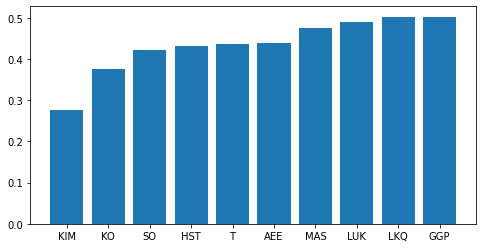

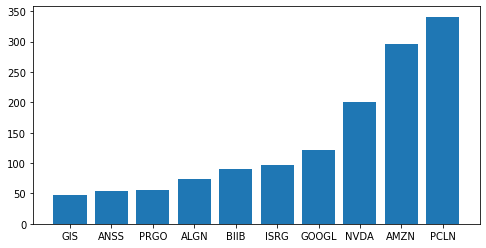

In [ ]:
error = dict(sorted(error.items(), key=lambda item: item[1]))
keys, values = zip(*error.items()) 

len(keys),len(values)
plt.figure(figsize=(8,4))
plt.bar(keys[:10], values[:10])
plt.show()
plt.figure(figsize=(8,4))
plt.bar(keys[-10:], values[-10:])
plt.show()
error_lstm_sme = error

**LSTM SMA-MACD**

AAPL 10.926019882843786


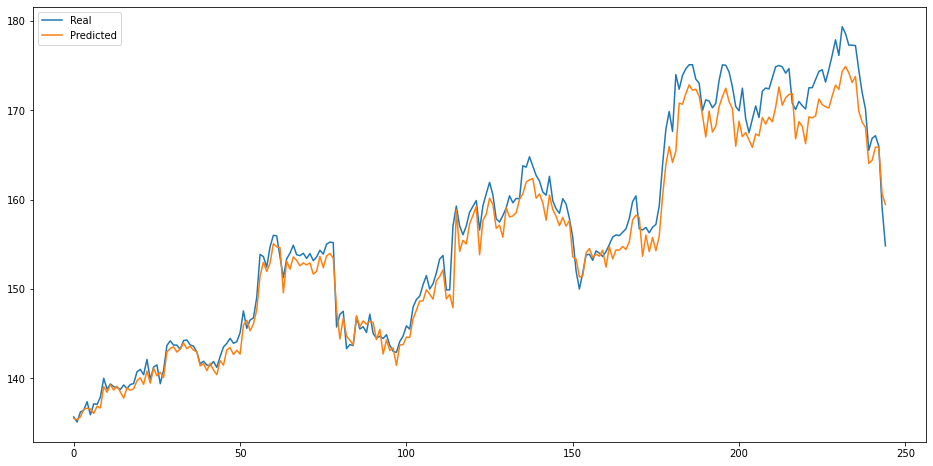

AMZN 95.01886393487963


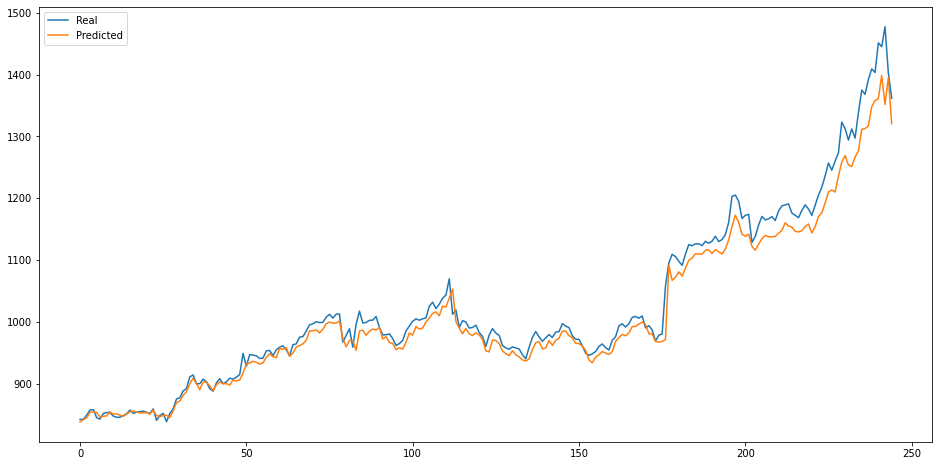

GOOGL 21.37620562553772


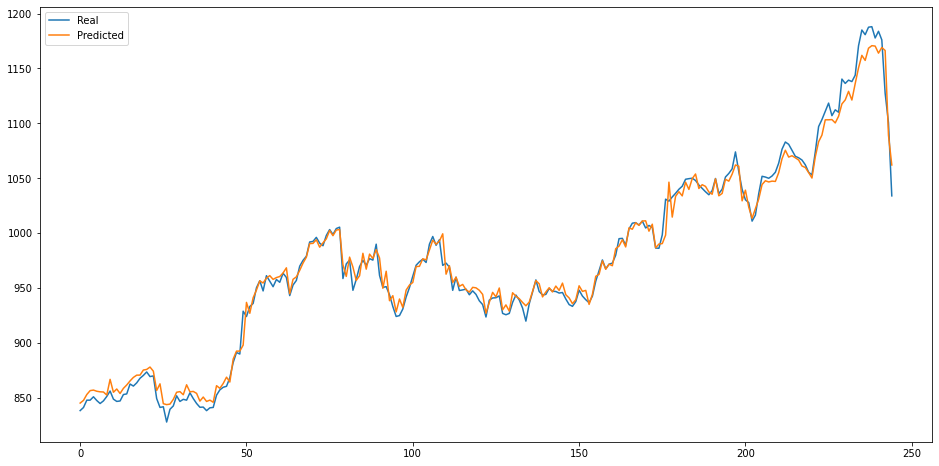

MSFT 2.7803486947131075


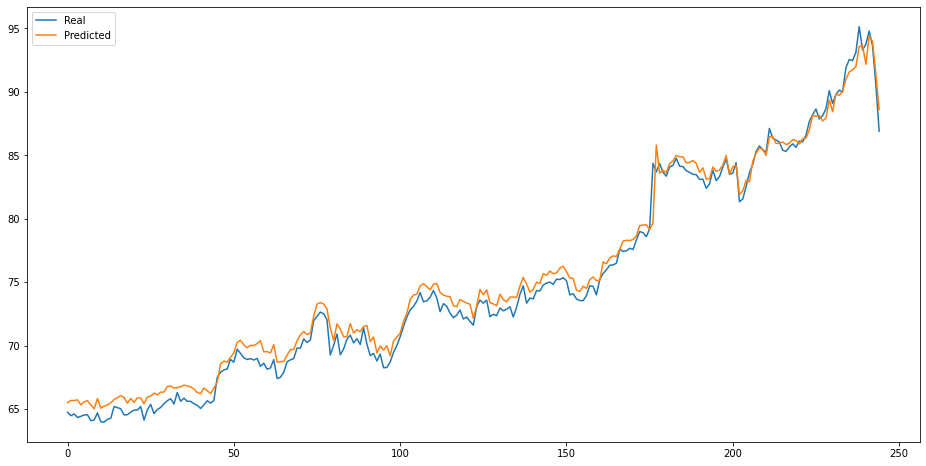

NFLX 36.67076664335618


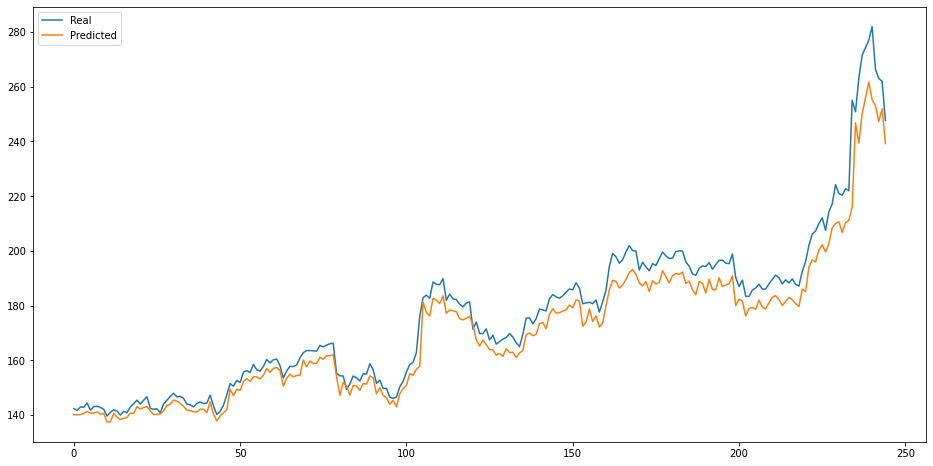

In [ ]:
history_points = 30
test_split = 0.8
error = {}
sp_all = create_sp_list()

for df_each in sp_all[:]:
    name = df_each['Name'][0]
    if name in stock_name:
        np.random.seed(4)
        tf.random.set_seed(4)
        ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = prepare_data_SMA_macd(df_each)
        n = int(ohlcv_histories.shape[0] * test_split)

        ohlcv_train = ohlcv_histories[:n]
        tech_ind_train = technical_indicators[:n]
        y_train = next_day_open_values[:n]

        ohlcv_test = ohlcv_histories[n:]
        tech_ind_test = technical_indicators[n:]
        y_test = next_day_open_values[n:]

        unscaled_y_test = unscaled_y[n:]

        lstm_input = Input(shape=(history_points, 11), name='lstm_input')
        dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

        x = LSTM(64, name='lstm_0')(lstm_input)
        x = Dropout(0.2, name='lstm_dropout_0')(x)
        lstm_branch = Model(inputs=lstm_input, outputs=x)
        y = Dense(20, name='tech_dense_0')(dense_input)
        y = Activation("relu", name='tech_relu_0')(y)
        y = Dropout(0.2, name='tech_dropout_0')(y)
        technical_indicators_branch = Model(inputs=dense_input, outputs=y)

        combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

        z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
        z = Dense(1, activation="linear", name='dense_out')(z)

        model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
        adam = optimizers.Adam(lr=0.0005)
        model.compile(optimizer=adam, loss='mse')
        model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=16, epochs=250, shuffle=True, validation_split=0.1,verbose=0)

        y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
        y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
        y_predicted = model.predict([ohlcv_histories, technical_indicators])
        y_predicted = y_normaliser.inverse_transform(y_predicted)
        real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
        scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
        error[name] = scaled_mse

        print(name,scaled_mse)
        start = 0
        end = -1
        plt.figure(figsize=(16,8))
        real = plt.plot(unscaled_y_test[start:end], label='real')
        pred = plt.plot(y_test_predicted[start:end], label='predicted')

        plt.legend(['Real', 'Predicted'])

        plt.show()

**LSTM- SMA-MACD with SN500 INDEX DATA**

---



**Hyperperameter tuning**

AAPL epoch:  100 neaurton:  8  --->  MSE: 189.61533432397212
AAPL epoch:  100 neaurton:  16  --->  MSE: 93.5126174787216
AAPL epoch:  200 neaurton:  16  --->  MSE: 13.270229508023393
AAPL epoch:  200 neaurton:  64  --->  MSE: 12.309474488075507
AAPL epoch:  250 neaurton:  32  --->  MSE: 23.7222551419903
AAPL epoch:  250 neaurton:  64  --->  MSE: 9.24005817417136
AAPL epoch:  300 neaurton:  64  --->  MSE: 6.611990121692571
AAPL epoch:  300 neaurton:  256  --->  MSE: 32.36363329957172


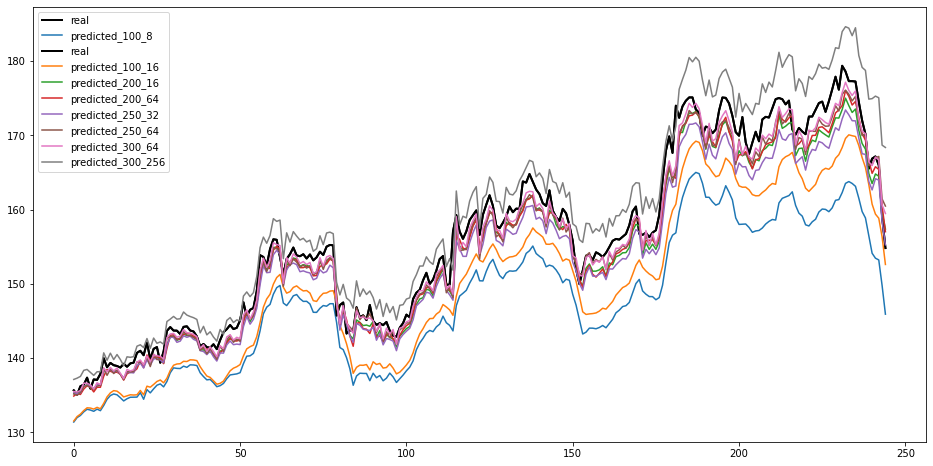

In [ ]:
history_points = 30
test_split = 0.8
error = {}
sp_all = create_sp_list()
perameter_tunining = {
    100: [8,16],
    200: [16,64],
    250: [32,64],
    300: [64,256]
}

for df_each in sp_all[:]:
    name = df_each['Name'][0]
    if name in stock_name:
        np.random.seed(4)
        tf.random.set_seed(4)
        ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = prepare_data_SMA_macd(df_each)
        n = int(ohlcv_histories.shape[0] * test_split)

        ohlcv_train = ohlcv_histories[:n]
        tech_ind_train = technical_indicators[:n]
        y_train = next_day_open_values[:n]

        ohlcv_test = ohlcv_histories[n:]
        tech_ind_test = technical_indicators[n:]
        y_test = next_day_open_values[n:]

        unscaled_y_test = unscaled_y[n:]

        lstm_input = Input(shape=(history_points, 11), name='lstm_input')
        dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')
        
        plt.figure(figsize=(16,8))

        for epoch,neaurons in perameter_tunining.items():
            for no in neaurons:
                x = LSTM(30, name='lstm_0')(lstm_input)
                x = Dropout(0.2, name='lstm_dropout_0')(x)
                lstm_branch = Model(inputs=lstm_input, outputs=x)
                y = Dense(20+no, name='tech_dense_0')(dense_input)
                y = Activation("relu", name='tech_relu_0')(y)
                y = Dropout(0.2, name='tech_dropout_0')(y)
                technical_indicators_branch = Model(inputs=dense_input, outputs=y)
                combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

                z = Dense(64+no, activation="sigmoid", name='dense_pooling')(combined)
                z = Dense(1, activation="linear", name='dense_out')(z)
                model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
                adam = optimizers.Adam(lr=0.0005)
                model.compile(optimizer=adam, loss='mse')
                model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=16, epochs=epoch, shuffle=True, validation_split=0.1,verbose=0)

                y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
                y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
                y_predicted = model.predict([ohlcv_histories, technical_indicators])
                y_predicted = y_normaliser.inverse_transform(y_predicted)
                real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
                scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
                error[name] = scaled_mse

                print(name,"epoch: ",epoch,"neaurton: ",no," ---> ","MSE:",scaled_mse)
                start = 0
                end = -1
                if epoch == 100:
                    
                    real = plt.plot(unscaled_y_test[start:end], label='real',linewidth=2,color='black')
                plt.plot(y_test_predicted[start:end], label='predicted_' + str(epoch)+ "_"+ str(no))
        plt.legend()
        plt.show()

In [ ]:
save = pd.DataFrame.from_dict([error_lstm_sme])
save.to_csv("/content/drive/MyDrive/DAL/mlbd/lstm_sma.csv")

**Train function for each stock**

In [16]:
history_points = 30
test_split = 0.9

def train_lstm_sme(df):
    error = {}
    # sp_all = create_sp_list()

    np.random.seed(4)
    tf.random.set_seed(4)

    ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = prepare_data_SMA_macd(df)
    # print(ohlcv_histories.shape,"--history")
    n = int(ohlcv_histories.shape[0] * test_split)

    ohlcv_train = ohlcv_histories[:]
    tech_ind_train = technical_indicators[:]
    y_train = next_day_open_values[:]

    lstm_input = Input(shape=(history_points, 11), name='lstm_input')
    dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

    x = LSTM(64, name='lstm_0')(lstm_input)
    x = Dropout(0.2, name='lstm_dropout_0')(x)
    lstm_branch = Model(inputs=lstm_input, outputs=x)
    y = Dense(20 +64, name='tech_dense_0')(dense_input)
    y = Activation("relu", name='tech_relu_0')(y)
    y = Dropout(0.2, name='tech_dropout_0')(y)
    technical_indicators_branch = Model(inputs=dense_input, outputs=y)

    combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

    z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
    z = Dense(1, activation="linear", name='dense_out')(z)

    model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
    adam = optimizers.Adam(lr=0.0005)
    model.compile(optimizer=adam, loss='mse')
    model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=16, epochs=250, shuffle=True, validation_split=0.1,verbose=0)

    return model

**Prediction function fo the next day**

In [15]:
def predict_next_day_open(model_,apple_daily_data_today):
    ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = prepare_data_SMA_macd(apple_daily_data_today)
    test_split = 0.9
    n = int(ohlcv_histories.shape[0] * test_split)

    ohlcv_test = ohlcv_histories[n:]
    tech_ind_test = technical_indicators[n:]
    y_test = next_day_open_values[n:]

    unscaled_y_test = unscaled_y[:]

    y_test_predicted = model_.predict([ohlcv_test, tech_ind_test])
    y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

    return y_test_predicted

**Testing and training on Apple data from 2013**

In [ ]:
ts = TimeSeries(key="60MT4TF138NOKPQY", output_format='pandas')
apple_daily, meta_data = ts.get_daily('AAPL', outputsize='full')

In [ ]:
apple_daily = apple_daily.iloc[::-1]

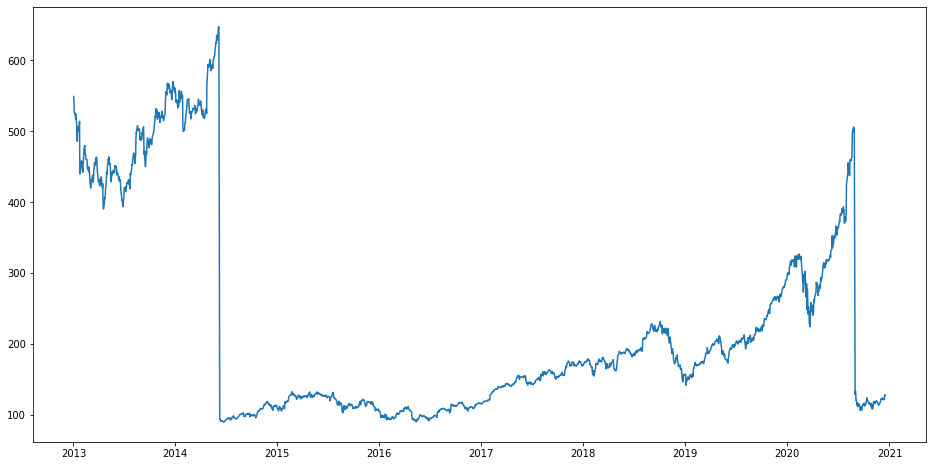

In [ ]:
mask = apple_daily.index >= '2013-01-01'
apple_daily = apple_daily.loc[mask]
plt.figure(figsize=(16,8))
plt.plot(apple_daily['4. close'], label='Close Price history')

In [ ]:
df_sp_500_all

Date  SNP_500_Open  ...  SNP_500_Adj Close  SNP_500_Volume
0    2013-01-17   1472.630005  ...        1480.939941      3706710000
1    2013-01-18   1480.949951  ...        1485.979980      3795740000
2    2013-01-22   1485.979980  ...        1492.560059      3570950000
3    2013-01-23   1492.560059  ...        1494.810059      3552010000
4    2013-01-24   1494.810059  ...        1494.819946      3699430000
...         ...           ...  ...                ...             ...
1989 2020-12-10   3659.129883  ...        3668.100098      4618240000
1990 2020-12-11   3656.080078  ...        3663.459961      4367150000
1991 2020-12-14   3675.270020  ...        3647.489990      4594920000
1992 2020-12-15   3666.409912  ...        3694.620117      4360280000
1993 2020-12-16   3696.250000  ...        3701.169922      4056950000

[1994 rows x 7 columns]

In [ ]:
apple_daily['Date'] = pd.to_datetime(apple_daily.index,format='%Y-%m-%d')
apple_daily = pd.merge(apple_daily, df_sp_500_all, how='outer', on='Date')
apple_daily = apple_daily.dropna()
apple_daily

1. open  2. high  ...  SNP_500_Adj Close  SNP_500_Volume
11    510.310   510.75  ...        1480.939941    3.706710e+09
12    498.516   502.22  ...        1485.979980    3.795740e+09
13    504.560   507.88  ...        1492.560059    3.570950e+09
14    508.810   514.99  ...        1494.810059    3.552010e+09
15    460.000   465.73  ...        1494.819946    3.699430e+09
...       ...      ...  ...                ...             ...
2000  120.500   123.87  ...        3668.100098    4.618240e+09
2001  122.430   122.76  ...        3663.459961    4.367150e+09
2002  122.600   123.35  ...        3647.489990    4.594920e+09
2003  124.340   127.90  ...        3694.620117    4.360280e+09
2004  127.410   128.37  ...        3701.169922    4.056950e+09

[1994 rows x 12 columns]

(197, 30, 11) (197, 2)
184.08540118104688


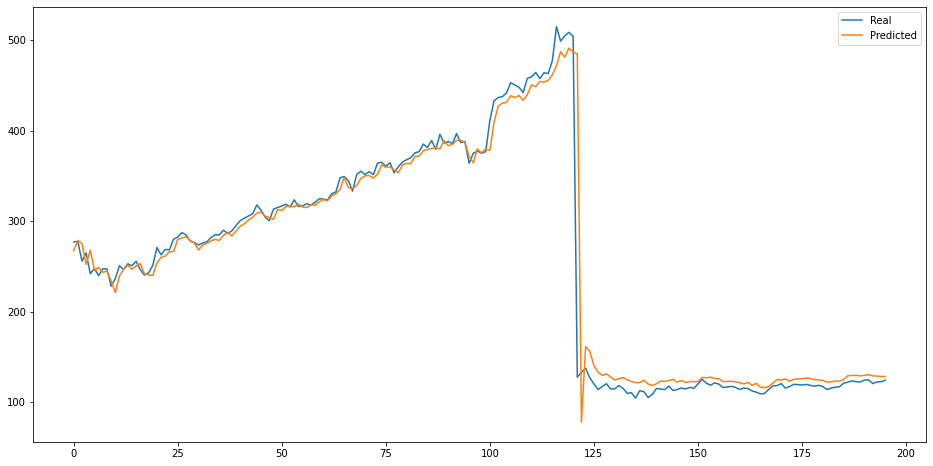

In [ ]:
train_lstm_sme(apple_daily)

**Portfolio Recommandation**


In [29]:
top_25 = ['AAPL','MSFT','AMZN','FB','GOOGL','GOOG','BRK.B','JNJ','PG','V','NVDA','HD','MA','JPM','UNH','VZ','ADBE','CRM','PYPL','NFLX','DIS','INTC','CMCSA','MRK','T']
#https://www.investopedia.com/ask/answers/08/find-stocks-in-sp500.asp

In [ ]:
portfolio_results = pd.DataFrame()

df_temp1 = df.drop_duplicates('Name')
df_live = pd.DataFrame()

count = 0
for each in df_temp1['Name'][:]:
    name = each
    if name in top_15:
      msft = yf.Ticker(name)
      data_frame = msft.history(period="max")
      df_live.append(data_frame)
      
      data_frame['Date'] = pd.to_datetime(data_frame.index,format='%Y-%m-%d')

      # mask for the dates from 2013 to 2017

      mask = data_frame.Date >= min_date
      data_frame = data_frame.loc[mask]
      data_frame = data_frame.assign(Name=name)
      data_frame = data_frame.reset_index(drop=True)

      if data_frame.shape[0] > 1200:
          data_frame['Date'] = pd.to_datetime(data_frame.Date,format='%Y-%m-%d')
          df_apple = pd.merge(data_frame, df_sp_500_all, how='inner', on='Date')
          df_apple.index = df_apple['Date']
          df_apple = df_apple.sort_index(ascending=True, axis=0)
          df_apple = df_apple.drop(['Dividends','Stock Splits','SNP_500_Stock Splits'],axis=1)
          df_apple = df_apple.dropna()
          apple_daily_data_today = df_apple[-32:-1]
          last_day_open = apple_daily_data_today.tail()['Open'][-1]
          apple_daily_data = df_apple[:-32]
          model = train_lstm_sme(apple_daily_data)

          pred = predict_next_day_open(model,apple_daily_data_today)
          next_day_predicted = pred[0][0]
          delta = next_day_predicted - last_day_open
          portfolio_results = portfolio_results.append({'name': name, 'last_day_open': last_day_open,
                                                        'next_day_predicted': next_day_predicted,
                                                        'delta': delta}, ignore_index=True)
          print(name,count)
          count+=1
portfolio_results.to_csv("/content/drive/MyDrive/portfolio_result.csv")

**Portfolio reccomadation** 

In [17]:
df= pd.read_csv("/content/drive/MyDrive/portfolio_result.csv")
df = df.sort_values('delta',ascending=False)
df = df[:10]

<Figure size 1152x576 with 0 Axes>

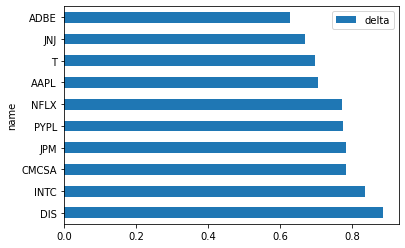

In [20]:
plt.figure(figsize=(16,8))
df.plot('name', 'delta', kind='barh')